In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

In [2]:
train_set='/kaggle/input/data/SAVE/train'
val_set='/kaggle/input/data/SAVE/val'
test_set='/kaggle/input/data/SAVE/test'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 16,
    shuffle=True,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')

Found 4535 images belonging to 8 classes.
Found 1294 images belonging to 8 classes.
Found 661 images belonging to 8 classes.


In [5]:
train_generator.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [6]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, GaussianNoise

base_model = EfficientNetB5(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.35))  # Add noise for regularization
model.add(GlobalAveragePooling2D())  # Pooling layer
model.add(Dense(256, activation='relu'))  # Dense layer
model.add(BatchNormalization())  # Add Batch Normalization
model.add(GaussianNoise(0.35))
model.add(Dropout(0.2))  # Dropout for further regularization
model.add(Dense(8, activation='softmax'))  # Final output layer for 8 classes

model.summary()

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)          │ (None, 7, 7, 2048)          │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_1 (GaussianNoise)     │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,041,151 (110.78 MB)

 Trainable params: 527,112 (2.01 MB)

 Non-trainable params: 28,514,039 (108.77 MB)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)
checkpoint = ModelCheckpoint('bestx_model.keras', monitor='val_loss', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


283/283 ━━━━━━━━━━━━━━━━━━━━ 258s 673ms/step - AUC: 0.8154 - Precision: 0.5261 - Recall: 0.3476 - accuracy: 0.4377 - loss: 1.6383 - val_AUC: 0.9708 - val_Precision: 0.8016 - val_Recall: 0.6313 - val_accuracy: 0.7469 - val_loss: 0.6687 - learning_rate: 1.0000e-04
Epoch 2/300
  1/283 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - AUC: 0.9799 - Precision: 0.7333 - Recall: 0.6875 - accuracy: 0.6875 - loss: 0.5060

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


283/283 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - AUC: 0.9799 - Precision: 0.7333 - Recall: 0.6875 - accuracy: 0.6875 - loss: 0.5060 - val_AUC: 0.9504 - val_Precision: 0.6154 - val_Recall: 0.5714 - val_accuracy: 0.6429 - val_loss: 0.8498 - learning_rate: 1.0000e-04
Epoch 3/300
283/283 ━━━━━━━━━━━━━━━━━━━━ 117s 405ms/step - AUC: 0.9574 - Precision: 0.7599 - Recall: 0.6699 - accuracy: 0.7139 - loss: 0.7692 - val_AUC: 0.9766 - val_Precision: 0.8020 - val_Recall: 0.7531 - val_accuracy: 0.7875 - val_loss: 0.5623 - learning_rate: 1.0000e-04
Epoch 4/300
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - AUC: 0.9565 - Precision: 0.6667 - Recall: 0.6250 - accuracy: 0.6250 - loss: 0.7959 - val_AUC: 0.9727 - val_Precision: 0.7692 - val_Recall: 0.7143 - val_accuracy: 0.7857 - val_loss: 0.6946 - learning_rate: 1.0000e-04
Epoch 5/300
283/283 ━━━━━━━━━━━━━━━━━━━━ 115s 400ms/step - AUC: 0.9677 - Precision: 0.8031 - Recall: 0.7257 - accuracy: 0.7661 - loss: 0.6484 - val_AUC: 0.9786 - val_Precision: 0.8125 - val_R

In [11]:
train_evaluation = model.evaluate(train_generator)

284/284 ━━━━━━━━━━━━━━━━━━━━ 94s 332ms/step - AUC: 0.9988 - Precision: 0.9529 - Recall: 0.9488 - accuracy: 0.9516 - loss: 0.1315


In [12]:
validation_evaluation = model.evaluate(validation_generator)

81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 299ms/step - AUC: 0.9845 - Precision: 0.8360 - Recall: 0.8192 - accuracy: 0.8269 - loss: 0.4295


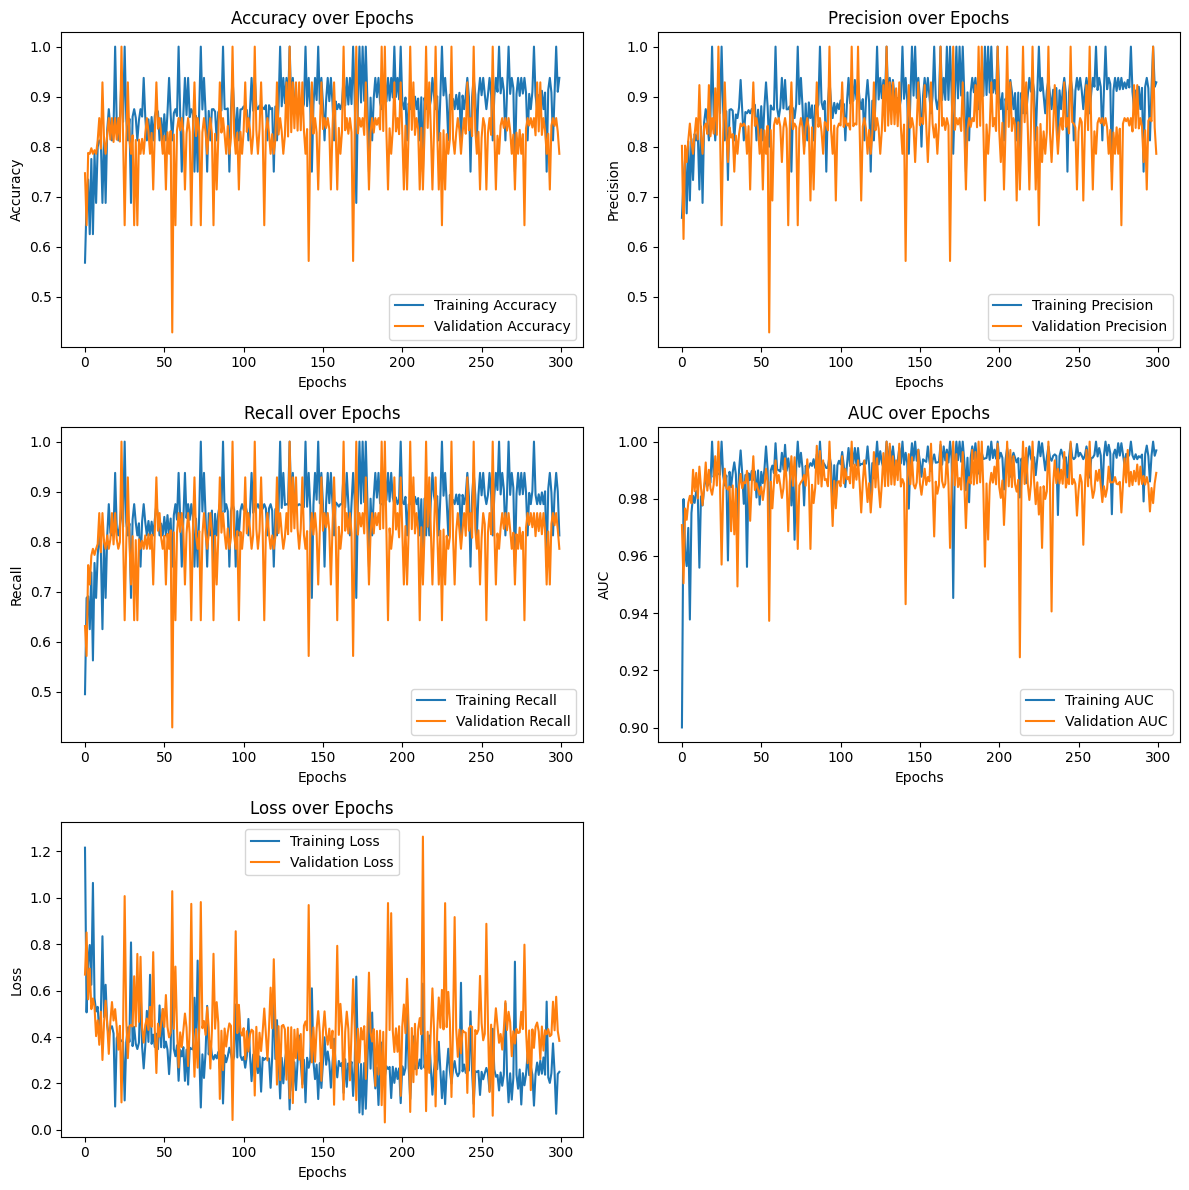

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision plot
plt.subplot(3, 2, 2)
plt.plot(history.history['Precision'], label='Training Precision')
plt.plot(history.history['val_Precision'], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(3, 2, 3)
plt.plot(history.history['Recall'], label='Training Recall')
plt.plot(history.history['val_Recall'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC plot
plt.subplot(3, 2, 4)
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Loss plot
plt.subplot(3, 2, 5)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


if 'lr' in history.history:
    plt.subplot(3, 2, 6)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()


plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

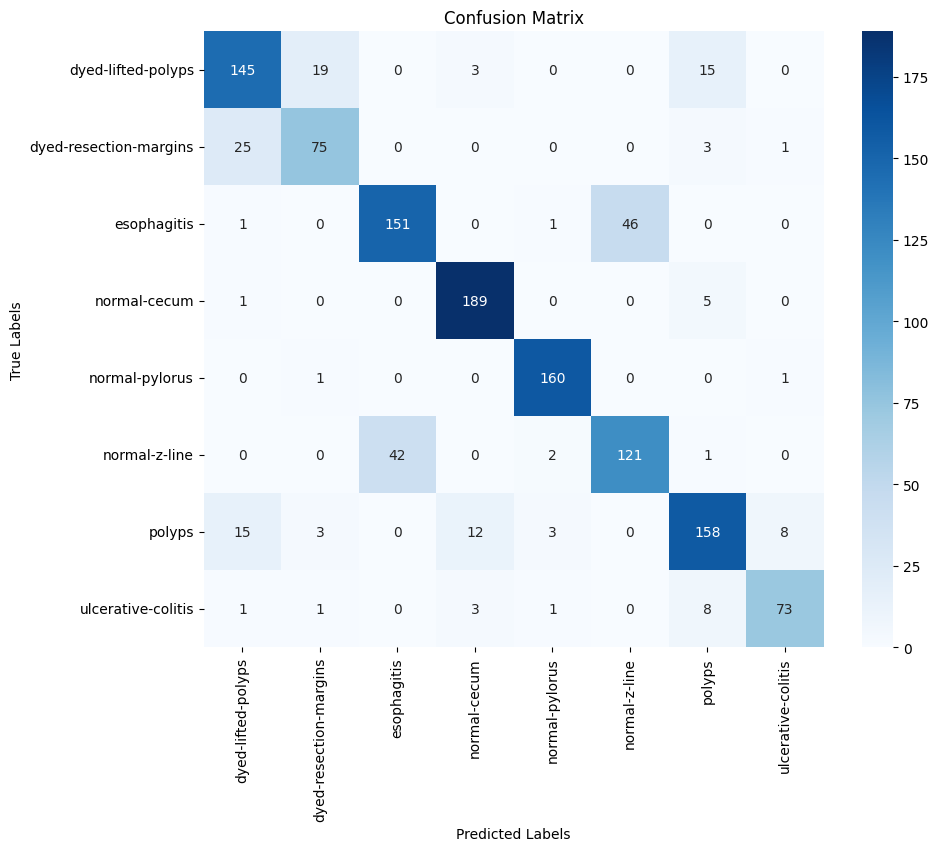

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.77      0.80      0.78       182
dyed-resection-margins       0.76      0.72      0.74       104
           esophagitis       0.78      0.76      0.77       199
          normal-cecum       0.91      0.97      0.94       195
        normal-pylorus       0.96      0.99      0.97       162
         normal-z-line       0.72      0.73      0.73       166
                polyps       0.83      0.79      0.81       199
    ulcerative-colitis       0.88      0.84      0.86        87

              accuracy                           0.83      1294
             macro avg       0.83      0.82      0.83      1294
          weighted avg       0.83      0.83      0.83      1294



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


test_generator.reset()


true_labels = []
predicted_probs = []


for i in range(len(validation_generator)):
    imgs, labels = next(validation_generator)
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_probs.extend(np.argmax(model.predict(imgs), axis=1))


cm = confusion_matrix(true_labels, predicted_probs)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, predicted_probs, target_names=list(validation_generator.class_indices.keys()))) 